<a href="https://colab.research.google.com/github/ayeshagunarathne/Vision-Transformers/blob/main/Swin_Transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is an implementation of the swin transformer architecture (Swin-T model is explained here) introduced through the paper titled: Swin Transformer: Hierarchical Vision Transformer using Shifted Windows** : https://arxiv.org/abs/2103.14030



**Key points from paper:**

The swin transformer architeture proposed in the paper consist of :
1. Hierachical transformer architecture:It starts from small-sized patches and then then gradually merge the neighbouring patches when moving into deeper transformer layers.
2. Has a linear computational complexity ( In Vit:a quadratic computational complexity is available).This is achieved by computing self-attention locally within non-overlapping windows that partition an image. The key design element here is the shift of the window partition between consecutive self-attention layers.




##**Architecture of SWIN-T**

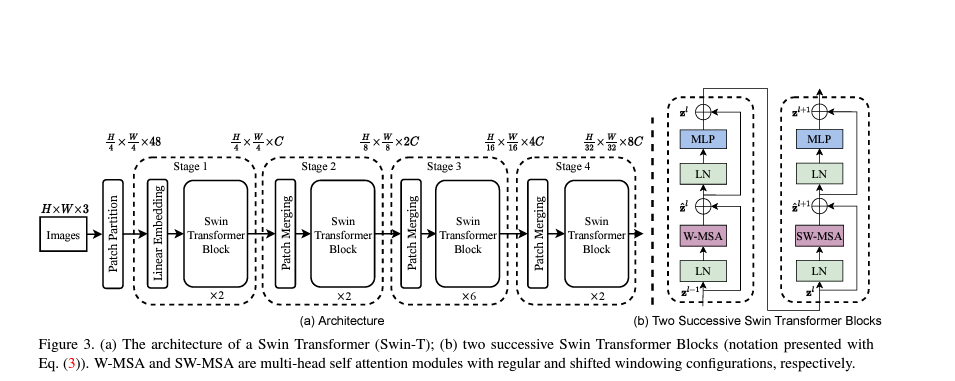



Image source:https://arxiv.org/abs/2103.14030



####**The hierachical structure**

In the above image,input image is of size 224x224x3 (H,W,C).Then image is divided into 4x4 patches.The resulting feature map is of size 56x56x48 (H/4,W/4,48).

If the embedding size C = 96.The input to stage 1 swin transformer block is of size 56x56x96.

The patch merging layer in stage 2 and after,reduces the spatial resolution of the feature map while increasing the channel dimension, effectively downsampling the feature map and increasing its representation power.

Patch merging in stage 2 converts the feature map size to 28x28x192 and then in stage 3 it is downsampled to 14x14x384 and finally in stage 4 it is downsampled to 7x7x768.

This is how hierachical structure is created in the swin transformer.Figure below further explains this process.


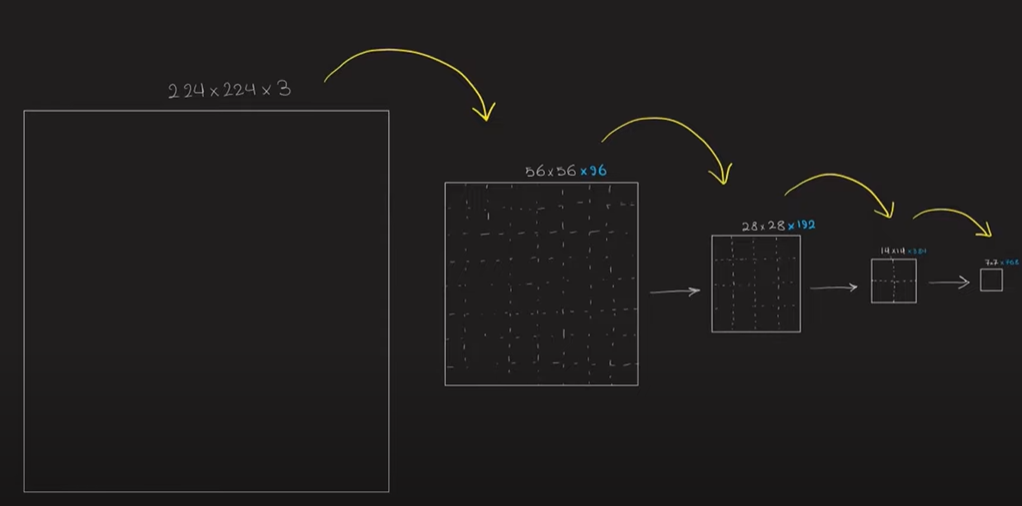

Image source:https://www.youtube.com/watch?v=LxPDpAiyqSU


* The Swin Transformer applies self-attention within **non-overlapping windows**.These windows are smaller regions within the overall feature map, which allow the model to focus on local patterns and reduce the computational complexity.

* More commonly,Self attention in swin transformer is calculated in 7x7 windows(There could be other window sizes depending on the architecture).

* In the image you can see how each of the feature map is divided into 7x7 windows.So for 56x56 spatial resolution ,there are 64 windows of size 7x7 and for 28x28 spatial resolution,16 windows and for 14x14 spatial resolution,there are 4 windows and finally it gets shrinked to 1 window of spatial size 7x7.




---


**Unlike Swin Transformer, where attention is computed locally within windows, in ViT, self-attention is calculated globally across all patches.This means that every patch in the image can attend to every other patch, allowing the model to capture long-range dependencies and global context within the entire image.**

**Summary: ViT computes attention across all patches globally, while Swin Transformer restricts attention to local windows.**

If we look at one 7x7 window, it has 49 pixels,so we consider each pixel as one token.There are 49 tokens then.

If we look at two adjacent 7x7 windows as shown below,the tokens in each window is separate and not related to each other.Only the relationship between the tokens within one window is calculated.


---


**So how do we identify the relationship between different windows then?**

        It is where the shifted windows are used.

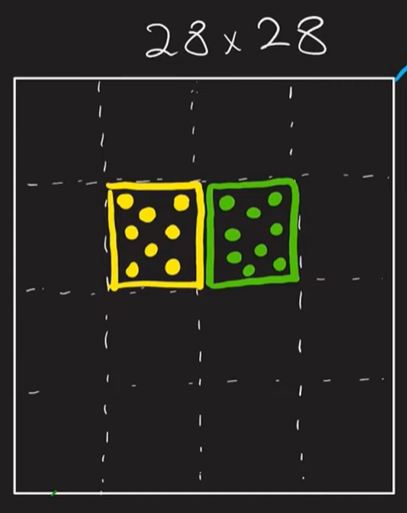

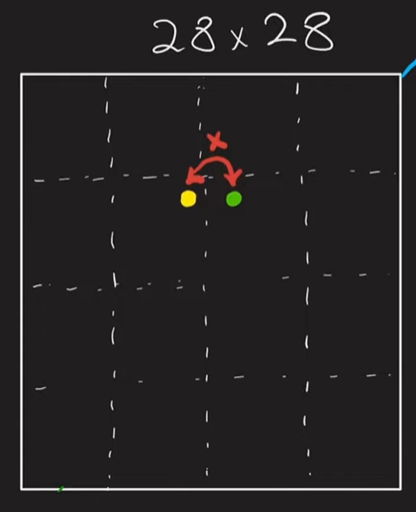

Image source:https://www.youtube.com/watch?v=LxPDpAiyqSU

####**Shifted window self-Attention**

"The standard Transformer architecture and its adaptation for image classification both conduct global self attention, where the relationships between a token and all other tokens are computed. The global computation leads to quadratic complexity with respect to the number of tokens, making it unsuitable for many vision problems requiring an immense set of tokens for dense prediction or to represent a high-resolution image."

"For efficient modeling, we propose to compute self-attention within local windows. The windows are arranged to evenly partition the image in a non-overlapping manner. Supposing each window contains M × M patches, the computational complexity of a global MSA module and a window based one on an image of h×w patches are:

\begin{aligned}
& \Omega(\mathrm{MSA})=4 h w C^2+2(h w)^2 C \\
& \Omega(\mathrm{W}-\mathrm{MSA})=4 h w C^2+2 M^2 h w C
\end{aligned}

  where the former is quadratic to patch number hw, and the latter is linear when M is fixed (set to 7 by default). Global self-attention computation is generally unaffordable for a large hw, while the window based self-attention is scalable.

  **(Extracted from original paper)**


---


Simultaneously all the windows are shifted to left and down by half of the size of a window.Now the two pixels shown in figure above belong to same window.Likewise this will capture the relationship between the different patches.




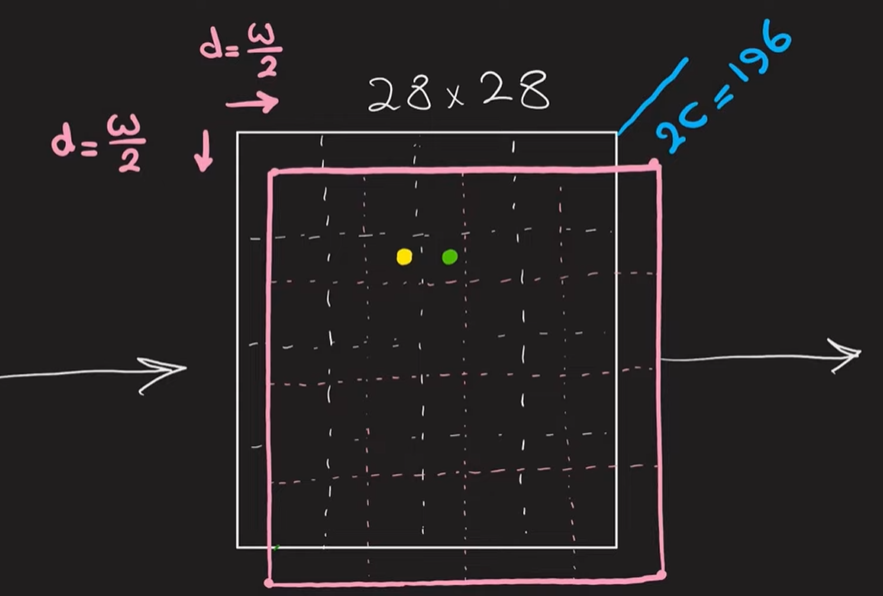

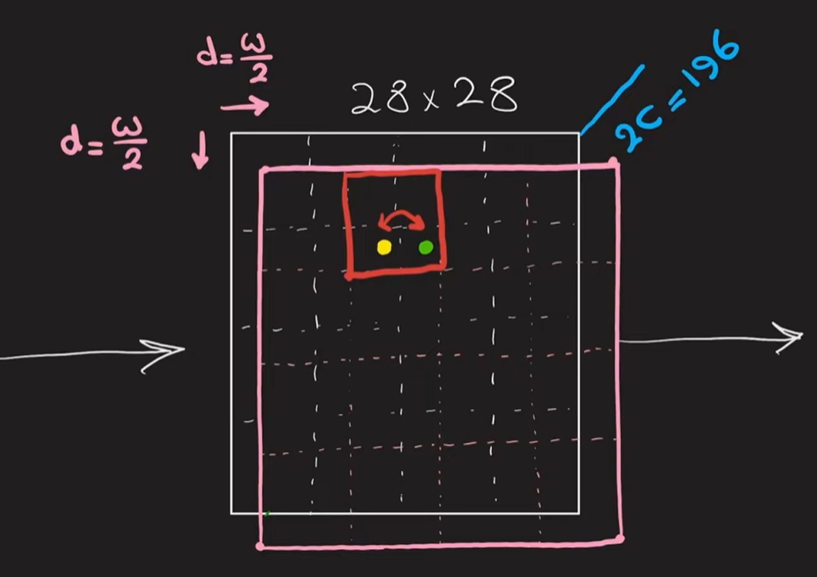

Image source: https://www.youtube.com/watch?v=LxPDpAiyqSU


In the original paper,the shifting of windows is shown as follows.Here they have 4x4 patches in layer l and then in the next layer it is shifted by 2,2.

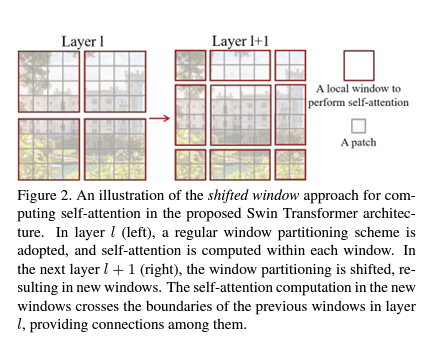

#### **Swin transformer block**

Each swin transformer block inside the 4 stages shown above,contain 2 swin trnasformer blocks connected as follows.


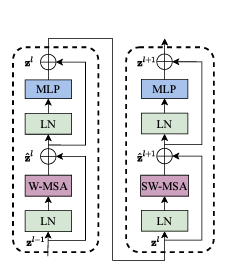

Swin Transformer is built by replacing the standard multi-head self attention (MSA) module in a Transformer block by a module based on shifted windows with other layers kept the same.

A Swin Transformer block consists of a shifted window based MSA module, followed by a 2-layer MLP with GELU nonlinearity in between. A LayerNorm (LN) layer is applied before each MSA module and each MLP, and a residual connection is applied after each module.This process can be mathematically expressed as follows.

\begin{aligned}
& \hat{\mathbf{z}}^l=\mathrm{W}-\mathrm{MSA}\left(\mathrm{LN}\left(\mathbf{z}^{l-1}\right)\right)+\mathbf{z}^{l-1} \\
& \mathbf{z}^l=\operatorname{MLP}\left(\operatorname{LN}\left(\hat{\mathbf{z}}^l\right)\right)+\hat{\mathbf{z}}^l \\
& \hat{\mathbf{z}}^{l+1}=\operatorname{SW-MSA}\left(\mathrm{LN}\left(\mathbf{z}^l\right)\right)+\mathbf{z}^l \\
& \mathbf{z}^{l+1}=\operatorname{MLP}\left(\operatorname{LN}\left(\hat{\mathbf{z}}^{l+1}\right)\right)+\hat{\mathbf{z}}^{l+1}
\end{aligned}

where $\hat{\mathbf{z}}^l$  and $\mathbf{z}^l$ denote the output features of the W-MSA module and the MLP module for block *l* ,respectively.

$\hat{\mathbf{z}}^{l+1}$  and $\mathbf{z}^{l+1}$ denote the output features of the SW-MSA module and the MLP module for block *l* +1 ,respectively

####**The 4 stages of the Architecture**
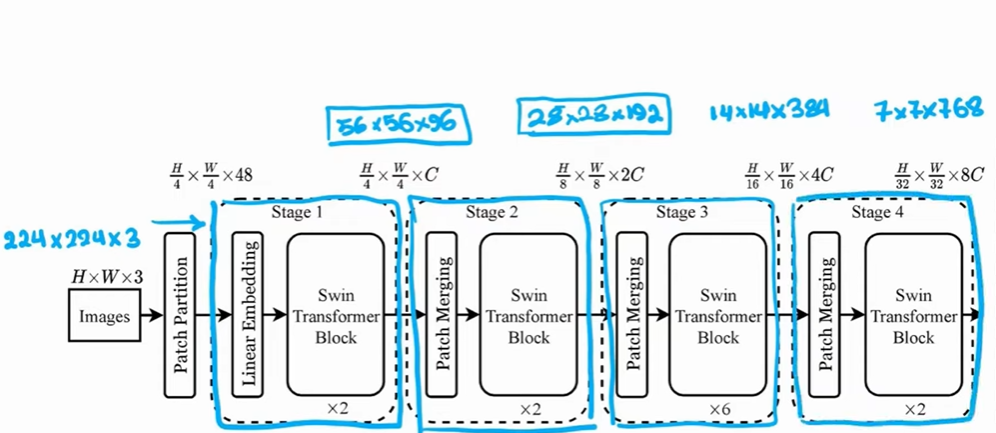


Image source: https://www.youtube.com/watch?v=Zz_b_hSIMd8

If we look at the 4 stages of the architecture separately, stage 1 has two modules for patch partitioning and linear embedding and all other stages contain path merging modules.

**STAGE 1:**
Input to stage 1 is of shape 224x224x3 (H,W,C).It is then divided into image patches of size 4x4 by the patch paritioning module.And this results in 4x4 patches with 3 color channels and when flattened it is 4x4x3 = 48.So output of this layer is 56x56x48.Linear embedding layer converts the image into 56x56x96.The linear layer projects each 48-dimensional vector into a higher-dimensional space, typically 96 dimensions.Mathematically, this is done by multiplying the 48-dimensional vector by a weight matrix of size 48x96. This results in a 96-dimensional output vector for each patch.


Input to swin transformer block is of size 56x56x96.There are 2 such swin transformer blocks (x2 denotes this number,this number can vary with the architecture) and within each swin transformer block,2 swin transformer blocks with W-MSA followed by 2 MLP layer and SW-MSA follwed by 2 MLP layer is available.(Number of MLP layers could also vary based on the architecture)


**STAGE 2:**
Input to stage 2 is of shape 56x56x96 (H,W,C).It is then passed through a patch merging layer.This change the spatial dimension to 28x28 and each patch in the new feature map is represented by 192 dimensions.So input to stage 2 swin transformer block is of shape 28x28x192

The process taking place in **STAGE 3** and **STAGE 4** is almost similar to **STAGE 2**.





## Sample Implementation of the Swin-T architecture

This is obtained from : https://github.com/berniwal/swin-transformer-pytorch/blob/master/swin_transformer_pytorch/swin_transformer.py

check the referenced github repository for more insightful details.

In [1]:
#This code is obtained from : https://github.com/berniwal/swin-transformer-pytorch/blob/master/swin_transformer_pytorch/swin_transformer.py
##Further explanations/comments and changes are done by myself

import torch
from torch import nn, einsum
import numpy as np
from einops import rearrange, repeat

#This class is used for window shifting.
#A circular shift (or roll) is applied to the input tensor along the spatial dimensions (height and width).
#This operation is critical in the Swin Transformer to allow cross-window connections by shifting the windows after the first attention layer, which ensures that information from different windows can interact.
class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))

#This is for the residual connection
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

#This class is used to implement layer normalization in the transformer block
#In transformers, Layer Normalization is often applied before self-attention or feedforward operations to stabilize training and improve performance.
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

"""
This class implements a standard feedforward neural network(Indicated as MLP in architecture above).
In the Swin Transformer, the feedforward network is applied after the window-based self-attention operations to further process the features.
The FeedForward class contains a two-layer feedforward network with a GELU activation function in between.
The first nn.Linear layer projects the input to a higher-dimensional space (hidden_dim), the GELU activation introduces non-linearity,
second nn.Linear layer projects it back to the original dimension (dim).

"""
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)
"""
The purpose of create_mask function:
When performing self-attention in the Swin Transformer, the input feature map is divided into smaller windows.
Self-attention is computed separately within each window, ensuring that the complexity remains manageable.
However, to allow for interactions between adjacent windows and to capture more global context, the windows are shifted (in a cyclic manner) by
a certain number of pixels.After this shift, parts of one window might overlap with another, leading to unintended interactions during the attention computation.

The create_mask function generates a binary mask (with values of -inf or 0) that is used to block these unintended interactions by setting attention scores
 between certain pairs of tokens to -inf, effectively preventing the model from considering those interactions.

The create_mask function is essential for controlling which parts of the input feature map can attend to each other during the windowed self-attention operations in
the Swin Transformer. It carefully masks out parts of the attention matrix to prevent unintended interactions between shifted windows,
ensuring that the attention mechanism only considers relevant pairs of tokens within the local context defined by the shifted windows.

"""

def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask


def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances


class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out


class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x


class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)
        return x


class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)


class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim * 8),
            nn.Linear(hidden_dim * 8, num_classes)
        )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = x.mean(dim=[2, 3])
        return self.mlp_head(x)





Example usage:

In [3]:
swin_t = SwinTransformer(
    hidden_dim=96,
    layers=(2, 2, 6, 2),
    heads=(3, 6, 12, 24),
    channels=3,
    num_classes=3,
    head_dim=32,
    window_size=7,
    downscaling_factors=(4, 2, 2, 2),
    relative_pos_embedding=True
)
x = torch.randn(1, 3, 224, 224)
logits = swin_t(x)  # (1,3)
print(swin_t)
print(logits)

SwinTransformer(
  (stage1): StageModule(
    (patch_partition): PatchMerging(
      (patch_merge): Unfold(kernel_size=4, dilation=1, padding=0, stride=4)
      (linear): Linear(in_features=48, out_features=96, bias=True)
    )
    (layers): ModuleList(
      (0): ModuleList(
        (0): SwinBlock(
          (attention_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): WindowAttention(
                (to_qkv): Linear(in_features=96, out_features=288, bias=False)
                (to_out): Linear(in_features=96, out_features=96, bias=True)
              )
            )
          )
          (mlp_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): FeedForward(
                (net): Sequential(
                  (0): Linear(in_features=96, out_features=384, bias=True)
                  (1): GELU(approximate='none


## **References:**

1. https://github.com/berniwal/swin-transformer-pytorch/blob/master/swin_transformer_pytorch/swin_transformer.py
2. https://www.youtube.com/watch?v=LxPDpAiyqSU


This is the original code implementation of swin transformer  https://github.com/microsoft/Swin-Transformer/blob/main/models/swin_transformer.py

